### ML with Pyspark
+ classify/predict winning team 
+ this will be more direct as all the job has been done in the supervised notebook I will be training and testing for the most part
### Data Source
+ https://www.kaggle.com/hikne707/big-five-european-soccer-leagues 

In [1]:
# Load our Packages
from pyspark import SparkContext

In [3]:
sc = SparkContext(master='local[2]')

#session = SparkSession.builder.appName("unsupervised").getOrCreate()
#session.stop()


In [4]:
# spark UI
sc

<SparkContext master=local[2] appName=PySparkShell>

In [5]:
# load spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("unsupervised").getOrCreate()

In [6]:
# load our dataset other data set that can be used ...
# France_league_V1.csv
# Spain_league_V1.csv
# Germany_league_V1.csv
# Italy_league_V1.csv
# Leagues.csv
df = spark.read.csv("D:/Senior/Capstone/data-science-enviroment/data/Leagues/Leagues_V1.csv", header=True, inferSchema=True)

For a detail explaination of what is goin on below and the data specs/ metrics refer to the Spark_Leagues_Unsupervised notebook in the same folder.This preprocess data is being transfered from there so it is made in 1 code block. 

In [7]:
import pyspark.ml
# load Ml packages
from pyspark.ml.feature import VectorAssembler, StringIndexer

In [8]:
# 2nd half goals full time - half time
df= df.withColumn("H2_Team_1", df['FT_Team_1']-df['HT_Team_1'])
df= df.withColumn("H2_Team_2", df['FT_Team_2']-df['HT_Team_2'])

#Rename HT to represent 1/2 halves, sorry for the redundency spark beginner
df= df.withColumnRenamed('HT_Team_1','H1_Team_1')
df= df.withColumnRenamed('HT_Team_2','H1_Team_2')

#Goal difference given, creating + for home win and - for away win
df= df.withColumn('FT_GD', df['FT_Team_1']-df['FT_Team_2'])
df= df.withColumn('H1_GD', df['H1_Team_1']-df['H1_Team_2'])
df= df.withColumn('H2_GD', df['FT_GD']-df['H1_GD'])

df = df.select('Round', 'Date', 'Team_1', 'Team_2', 'Year', 'Country', 'FT_Team_1', 'FT_Team_2', 'H1_Team_1', 'H1_Team_2', 'GGD', 'Team_1_(pts)', 'Team_2_(pts)', 'H2_Team_1', 'H2_Team_2', 'FT_GD', 'H1_GD', 'H2_GD', 'Outcome')

# Split the date column to get month, then label encode month
from pyspark.sql.functions import split
df = df.withColumn('Month', split(df['Date'],' ').getItem(2))

# convert the string Month into numbers
# label encoding
monthEncoder = StringIndexer(inputCol='Month',outputCol='Game_Month').fit(df)
df = monthEncoder.transform(df)
# I removed the features that can only be know after the full game is played
df = df.select('Round', 'Team_1', 'Team_2', 'Year', 'Country', 'H1_Team_1', 'H1_Team_2', 'Outcome')
required_features = ['Round', 'Team_1', 'Team_2', 'Year', 'Country', 'H1_Team_1', 'H1_Team_2']
Outcome = ['Outcome']

In [9]:
# VectorAssembly
vec_assembler = VectorAssembler(inputCols=required_features,outputCol='features')
#sticking entire feature required in a vector which I will be using to Model 
vec_df = vec_assembler.transform(df)
vec_assembler_results = VectorAssembler(inputCols=Outcome,outputCol='matchResults')
matchResult = vec_assembler_results.transform(vec_df)

In [17]:
from pyspark.ml.feature import ChiSqSelector

selector = ChiSqSelector( featuresCol="features",
                         outputCol="selectedFeatures", labelCol="Outcome")
result = selector.fit(matchResult ).transform(matchResult )

### All caught up to the pre-processing 

In [18]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='selectedFeatures',outputCol='standardized')
data_scale=scale.fit(result)
data_scale_output=data_scale.transform(result)


In [19]:
data_scale_output.toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,44259,44260,44261,44262,44263,44264,44265,44266,44267,44268
Round,1,1,1,1,1,1,1,1,1,1,...,25,25,25,25,26,26,26,26,26,26
Team_1,28,38,63,127,129,135,185,220,222,26,...,176,178,206,56,145,8,200,208,116,207
Team_2,130,150,80,184,198,65,137,123,41,131,...,40,197,29,19,175,99,110,11,86,45
Year,1995,1995,1995,1995,1995,1995,1995,1995,1995,1995,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
Country,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
H1_Team_1,3,1,0,0,0,1,1,1,2,1,...,2,1,2,1,0,0,0,0,0,1
H1_Team_2,0,0,0,0,1,0,3,0,2,1,...,0,0,2,2,0,2,1,0,0,0
Outcome,1,1,3,1,3,1,2,2,1,3,...,1,1,2,2,2,2,1,3,1,1
features,"[1.0, 28.0, 130.0, 1995.0, 0.0, 3.0, 0.0]","[1.0, 38.0, 150.0, 1995.0, 0.0, 1.0, 0.0]","[1.0, 63.0, 80.0, 1995.0, 0.0, 0.0, 0.0]","[1.0, 127.0, 184.0, 1995.0, 0.0, 0.0, 0.0]","[1.0, 129.0, 198.0, 1995.0, 0.0, 0.0, 1.0]","[1.0, 135.0, 65.0, 1995.0, 0.0, 1.0, 0.0]","[1.0, 185.0, 137.0, 1995.0, 0.0, 1.0, 3.0]","[1.0, 220.0, 123.0, 1995.0, 0.0, 1.0, 0.0]","[1.0, 222.0, 41.0, 1995.0, 0.0, 2.0, 2.0]","[1.0, 26.0, 131.0, 1995.0, 0.0, 1.0, 1.0]",...,"[25.0, 176.0, 40.0, 2019.0, 4.0, 2.0, 0.0]","[25.0, 178.0, 197.0, 2019.0, 4.0, 1.0, 0.0]","[25.0, 206.0, 29.0, 2019.0, 4.0, 2.0, 2.0]","[25.0, 56.0, 19.0, 2019.0, 4.0, 1.0, 2.0]","[26.0, 145.0, 175.0, 2019.0, 4.0, 0.0, 0.0]","[26.0, 8.0, 99.0, 2019.0, 4.0, 0.0, 2.0]","[26.0, 200.0, 110.0, 2019.0, 4.0, 0.0, 1.0]","[26.0, 208.0, 11.0, 2019.0, 4.0, 0.0, 0.0]","[26.0, 116.0, 86.0, 2019.0, 4.0, 0.0, 0.0]","[26.0, 207.0, 45.0, 2019.0, 4.0, 1.0, 0.0]"
matchResults,[1.0],[1.0],[3.0],[1.0],[3.0],[1.0],[2.0],[2.0],[1.0],[3.0],...,[1.0],[1.0],[2.0],[2.0],[2.0],[2.0],[1.0],[3.0],[1.0],[1.0]


#### Train/Test/Split

In [20]:
train_df,test_df = data_scale_output.randomSplit([0.7,0.3])
test_df.count()

13295

### Model Building
+ k-means: aims to partition data into k clusters in a way that data points in the same cluster are similar and data points in the different clusters are farther apart. Similarity of two points is determined by the distance between them.
+ silhouette score: The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [21]:
#importing models/eval
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [22]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean',)

# I do not know what value I want to use for K (clusters) so I am setting a loop to run through K to determine the correct amount of clusters, will evaluate later
for i in range(2,10):
    
    KMeans_model=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_model.fit(train_df.select('standardized'))
    
    output=KMeans_fit.transform(test_df.select('standardized'))
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)

    #print("Silhouette Score:",score)


Text(0, 0.5, 'silhouette_score')

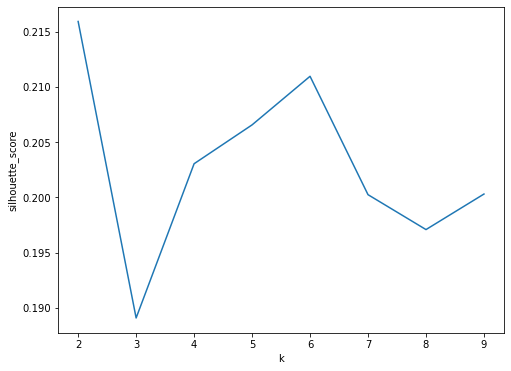

In [23]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('silhouette_score')

The fluctuation in the graph above makes sense, since there is litte to no clusters withing the dataset the algorithm is having a hard time, I prefer going ahead with K=5 where a local maxima of Silhouette Score is. Since there is no correct answer for what value of K is good, we can restore to descriptive statistics and plots to check the distribution. This is where spark lacks, we can use sklearn and see some of the PCA(principal component analysis) implemenation, for example the elbow plot.

In [24]:
#atempt to display Clusters

In [25]:
KMeans_model=KMeans(featuresCol='standardized', k=5)
y_pred = KMeans_model.fit(train_df.select('standardized'))
y_pred_kmean = y_pred.transform(test_df.select('standardized'))
y_pred_kmean.toPandas().transpose()


,0,1,2,3,4,5,6,7,8,9,...,13285,13286,13287,13288,13289,13290,13291,13292,13293,13294
standardized,"[0.09350721717092111, 0.0, 3.2489747365154513,...","[0.09350721717092111, 0.015181795730958233, 0....","[0.09350721717092111, 0.015181795730958233, 2....","[0.09350721717092111, 0.06072718292383293, 0.5...","[0.09350721717092111, 0.06072718292383293, 0.5...","[0.09350721717092111, 0.06072718292383293, 1.6...","[0.09350721717092111, 0.07590897865479117, 3.0...","[0.09350721717092111, 0.10627257011670763, 0.6...","[0.09350721717092111, 0.10627257011670763, 1.3...","[0.09350721717092111, 0.10627257011670763, 1.7...",...,"[3.740288686836845, 2.4290873169533174, 2.8390...","[3.740288686836845, 2.5049962956081084, 0.3188...","[3.833795904007766, 0.7894533780098281, 0.4706...","[3.833795904007766, 0.7894533780098281, 2.5354...","[3.833795904007766, 2.4290873169533174, 2.3684...","[3.833795904007766, 2.4442691126842755, 0.4706...","[3.927303121178687, 0.455453871928747, 2.39877...","[3.927303121178687, 1.7307247133292385, 0.4554...","[3.927303121178687, 2.3987237254914007, 1.2449...","[3.927303121178687, 2.7630868230343983, 3.0819..."
prediction,3,3,3,4,3,3,3,3,3,3,...,2,2,2,4,2,2,2,2,2,2


## Visualization

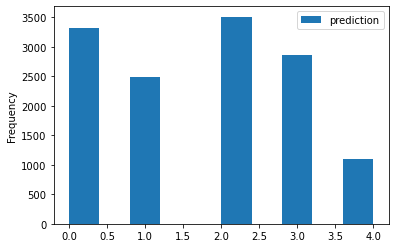

In [26]:
# I have to convert pandas I found histogram method in pandas, but not in spark.SQL module

x = y_pred_kmean.select('prediction').toPandas()  # symboling is the column for histogram
x.plot(kind='hist')

In [27]:
#sql for joining data and result
combined_result = y_pred_kmean.join(test_df, on='standardized', how='inner')
combined_result.toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,13285,13286,13287,13288,13289,13290,13291,13292,13293,13294
standardized,"[0.09350721717092111, 0.0, 3.2489747365154513,...","[0.09350721717092111, 0.015181795730958233, 0....","[0.09350721717092111, 0.015181795730958233, 2....","[0.09350721717092111, 0.06072718292383293, 0.5...","[0.09350721717092111, 0.06072718292383293, 0.5...","[0.09350721717092111, 0.06072718292383293, 1.6...","[0.09350721717092111, 0.07590897865479117, 3.0...","[0.09350721717092111, 0.10627257011670763, 0.6...","[0.09350721717092111, 0.10627257011670763, 1.3...","[0.09350721717092111, 0.10627257011670763, 1.7...",...,"[3.740288686836845, 2.4290873169533174, 2.8390...","[3.740288686836845, 2.5049962956081084, 0.3188...","[3.833795904007766, 0.7894533780098281, 0.4706...","[3.833795904007766, 0.7894533780098281, 2.5354...","[3.833795904007766, 2.4290873169533174, 2.3684...","[3.833795904007766, 2.4442691126842755, 0.4706...","[3.927303121178687, 0.455453871928747, 2.39877...","[3.927303121178687, 1.7307247133292385, 0.4554...","[3.927303121178687, 2.3987237254914007, 1.2449...","[3.927303121178687, 2.7630868230343983, 3.0819..."
prediction,3,3,3,4,3,3,3,3,3,3,...,2,2,2,4,2,2,2,2,2,2
Round,1,1,1,1,1,1,1,1,1,1,...,40,40,41,41,41,41,42,42,42,42
Team_1,0,1,1,4,4,4,5,7,7,7,...,160,165,52,52,160,161,30,114,158,182
Team_2,214,0,180,34,34,108,199,40,86,116,...,187,21,31,167,156,31,158,30,82,203
Year,2000,2010,2016,2009,2011,2017,2011,2012,2004,2018,...,1996,1995,1995,1996,1995,1996,1995,1996,1996,1995
Country,3,3,3,3,3,3,2,4,4,4,...,1,1,1,1,1,1,1,1,1,1
H1_Team_1,0,1,1,1,1,0,0,0,2,1,...,0,3,0,1,1,2,0,3,1,1
H1_Team_2,0,0,0,2,0,0,1,0,1,1,...,0,1,0,2,0,0,0,1,1,0
Outcome,2,2,1,3,1,2,2,1,3,2,...,2,1,3,3,1,1,1,1,2,1


Now, to better comprehend the prediction result, we plot the Team1, Team2, H1_Team1 and H2_team2 values for each cluster in a box plot.for better undertanding of the independent clustering and how they were defined. Without much detailed analytical understaing, this box plot is all over the place, not one cluster dominates over the other
The resulting graph reveals these key points:

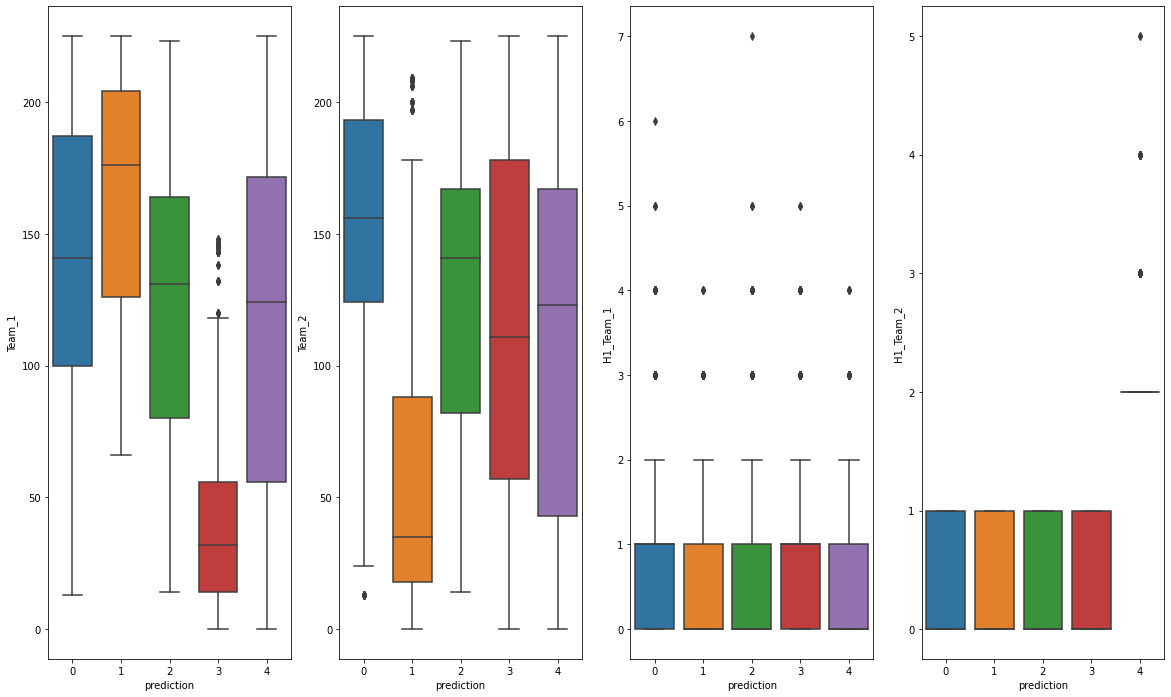

In [28]:
import seaborn as sns
analysis_df = combined_result.toPandas()

fig, ax = plt.subplots(1, 4, figsize=(20, 12))
sns.boxplot(x='prediction', y='Team_1', data=analysis_df, ax=ax[0])
sns.boxplot(x='prediction', y='Team_2', data=analysis_df, ax=ax[1])
sns.boxplot(x='prediction', y='H1_Team_1', data=analysis_df, ax=ax[2])
sns.boxplot(x='prediction', y='H1_Team_2', data=analysis_df, ax=ax[3])



Pairwise comparison: is a process of comparing alternatives in pairs, provides an easy visual to rank descision making.

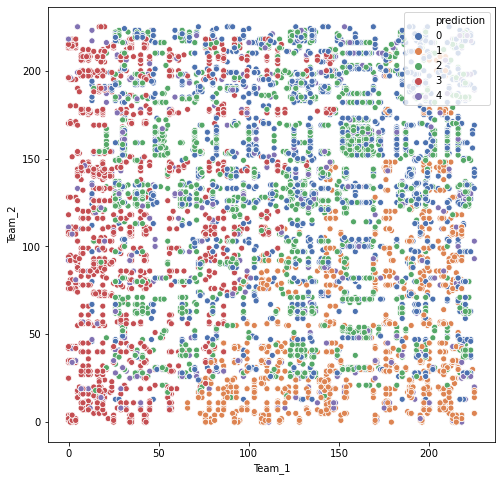

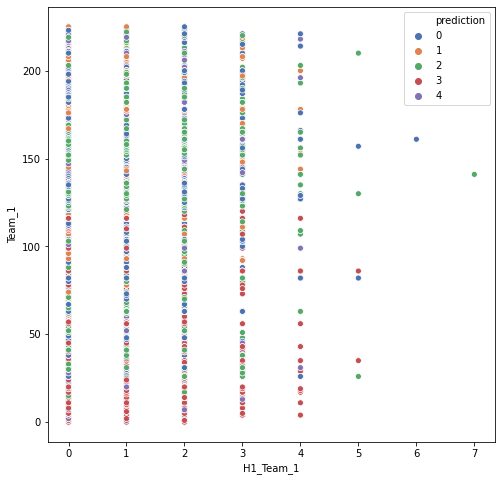

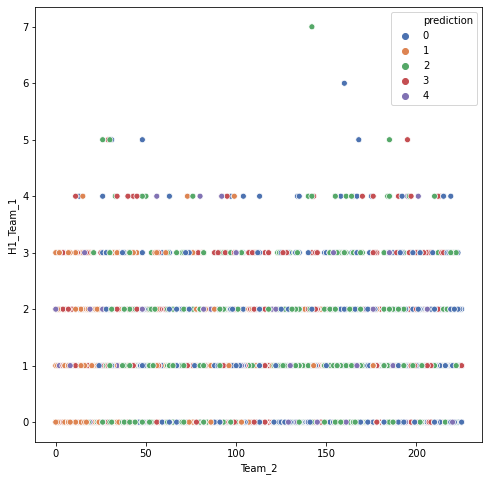

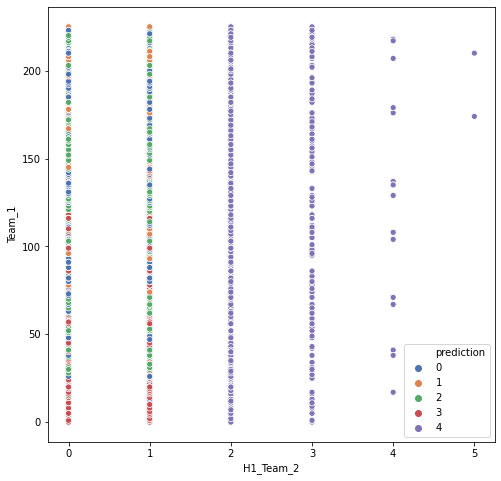

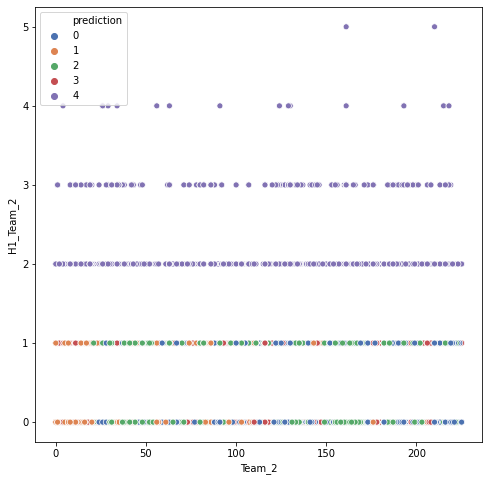

In [29]:
# Team 1 vs Team 2 (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Team_1', y='Team_2', 
                data=combined_result.toPandas(), 
                hue='prediction', 
                palette="deep")

# H1_Team_1 vs Team 1 (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='H1_Team_1', y='Team_1', 
                data=combined_result.toPandas(), 
                hue='prediction', 
                palette="deep")

# Team 2 vs H1_Team_1 (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Team_2', y='H1_Team_1', 
                data=combined_result.toPandas(), 
                hue='prediction', 
                palette="deep")

# H1_Team_2 vs Team 1 (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='H1_Team_2', y='Team_1', 
                data=combined_result.toPandas(), 
                hue='prediction', 
                palette="deep")

# Team 2 vs H1_Team_2 (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Team_2', y='H1_Team_2', 
                data=combined_result.toPandas(), 
                hue='prediction', 
                palette="deep")

## Conclusion
This as you can see from the clusters created above there was no corelation or actuatl "clusters" created. We can see this already by looking at aout elbow chart. The data set came with minimal features and with attempt to add my own, i t consisted of redunency instead, which ended up being dropped. This data requires more features for someone to accurately distinguish or find a parttern in two teams competing. This project was done in pyspark, but sometimes would be switch back to pandas since pyspark is a working progress. I would say pyspark is faster when working with large data set like. unspervised learning(predicting a game before it is played) with a model on this data set is not efficient. 

There some fascinating probability which can help you maximize your chances, this topic dives deeper within my report. With all this being said you are probably wondering were is the prediction method, from pyspark 2.2 there has not been one. To account for this I will be emulating this model and metrics in sklearn,with 2 added models. xgboost and random forest classifier, pyspark only supports binary clasification for those, hence it is a litle behind